# BDA Data Engineer Challenge

Submitted by Sam Bost, 19-Jan-20

### Greetings from Brisbane!

Sam here, hope this notebook finds you well.

The notebook below aims to answer each of the 5 questions. To the genius who created this challenge, thanks for making the questions clear and easy to follow!

The format for the notebook is as follows:

1. Extract, Transform and Load data using CKAN API.
2. Answer Each Question.

## 1. Extract, Transform and Load using CKAN API.

### Step 0: Import Libraries

In [1]:
#to handle certificate verification
import certifi

#to manage the JSON data
import json

#import pandas and numpy
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

#handling the certificate verification
import urllib3
from urllib3 import request

#turn-off warnings, after acknowledgement and rectification as required.
import warnings
warnings.filterwarnings("ignore")

### Step 1: Certificate Validatation

In [2]:
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                          ca_certs=certifi.where())

#noting in the urllib3 documentation, the value in using certifi to avoid unnecessary cybersecurity risk. 

### Step 2: Retrieve data from CKAN Data API

In [3]:
#Note If you face an error due to 'IOPub data rate exceeded in Jupyter notebook (when viewing image)', return to the command line and try 'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'.

#Note: Limit set based on number of rows. Attempting to capture all the data available.
url = 'https://data.gov.au/data/api/3/action/datastore_search?resource_id=809c77d8-fd68-4a2c-806f-c63d64e69842&limit=45000'
r = http.request('GET',url)

#check status
r.status

200

Status Codes Check:
- 200: All ok, result returned if available.
- 301: Redirected to different endpoint. Possible that a company has switched domain names, or changed the endpoint name.
- 400: Bad request.
- 401: Server says not authenticated.
- 403: Incorrect permissions.
- 404: Not found on the server.
- 503: Server unable to handle request.

In [4]:
#load JSON data
data = json.loads(r.data.decode('utf-8'))

In [5]:
#JSON to Python & Pandas
df_1 = pd.json_normalize(data)
df_1.head()
#User help: If you get an 'pandas does not have json_normalize' error, update to Pandas 1.0.3. Pandas prior to version 1 doesn't have json_normalize.

,help,success,result.include_total,result.resource_id,result.fields,result.records_format,result.records,result.limit,result._links.start,result._links.next,result.total
0,https://data.gov.au/data/api/3/action/help_sho...,True,True,809c77d8-fd68-4a2c-806f-c63d64e69842,"[{'type': 'int', 'id': '_id'}, {'type': 'text'...",objects,"[{'_id': 39224, 'Month': '43070', 'Airline': '...",45000,/api/3/action/datastore_search?limit=45000&res...,/api/3/action/datastore_search?offset=45000&li...,42797


While computers might appreciate a nice nested JSON object, it means we have to identify the elements of interest and format the query correctly! 

In [6]:
df = pd.json_normalize(data,["result", "records"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42797 entries, 0 to 42796
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   _id                   42797 non-null  int64 
 1   Month                 42797 non-null  object
 2   Airline               42797 non-null  object
 3   Port_Country          42797 non-null  object
 4   Passengers_In         42797 non-null  object
 5   Freight_In_(tonnes)   42797 non-null  object
 6   Mail_In_(tonnes)      42797 non-null  object
 7   Passengers_Out        42797 non-null  object
 8   Freight_Out_(tonnes)  42797 non-null  object
 9   Mail_Out_(tonnes)     42797 non-null  object
 10  Year                  42797 non-null  object
 11  Month_num             42797 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.9+ MB


In [7]:
#adding a column that records the month and year as a single column.
from datetime import datetime
df['Month-Year'] = df.apply(lambda row: datetime.strptime(f"{int(row.Year)}-{int(row.Month_num)}", '%Y-%m'), axis=1)
df['Month-Year'] = pd.to_datetime(df['Month-Year'])
df.head()

,_id,Month,Airline,Port_Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Year,Month_num,Month-Year
0,39224,43070,Qantas Airways,Thailand,6542,213.459,37.112,7112,86.277,13.115,2017,12,2017-12-01
1,11233,34943,Air France,France,694,13.081,3.191,383,4.797,0.208,1995,9,1995-09-01
2,26264,39326,Merpati Nusantara Airlines,Indonesia,160,0,0,180,0,0,2007,9,2007-09-01
3,37876,42705,Indonesia AirAsia,Indonesia,12907,0,0,15862,0,0,2016,12,2016-12-01
4,29007,40148,United Parcel Service,USA,0,1436.927,0,0,0,0,2009,12,2009-12-01


Awesome! We have a pandas dataframe with all the variables of interest. Time to see what we can learn from the dataset by answering each question.

## Question 1: How many passengers came in and out of Australia for each Airline in each month of 2019? 

Before we dive in, let's try to break down the required output.

The dataset, is scheduled operations of international airlines, operating to and from Australia.

- We're looking at just the 'Year' 2019.
- We're looking to aggregate 'Passengers_In' and 'Passengers_Out', based on the Airline and the Month.

In [8]:
#Let's refine the dataframe with the attributes of interest, and refine to the year of interest.
df_Q1 = df[['Port_Country','Passengers_In','Passengers_Out','Month_num','Airline','Year']].copy()

In [9]:
#Refining the dataset to the year of interest for this question
df_Q1 = df_Q1[df_Q1['Year'] == '2019']

In [10]:
#convert key numerical data into float format.
df_Q1[['Passengers_In','Passengers_Out','Month_num','Year']] = df_Q1[['Passengers_In','Passengers_Out','Month_num','Year']].astype(float)

In [11]:
#Using the 'groupby' functionality, to calculate the cumulative passengers in and out for each airline, for each month.
#In case there is multiple entries for any given airline for a given month.
Q1_Output = df_Q1.groupby(['Airline','Month_num'])[['Passengers_In','Passengers_Out']].apply(sum)
Q1_Output = Q1_Output.sort_values(['Airline','Month_num'])
Q1_Output.head()

Passengers_In  Passengers_Out
Airline                     Month_num                               
Air Caledonie International 1.0               8291.0          7336.0
                            2.0               3889.0          6148.0
                            3.0               3957.0          4409.0
                            4.0               4965.0          4911.0
                            5.0               3996.0          3786.0

In [12]:
Q1_Output.to_csv('Question 1 - SBost.csv')

## Quesion 2:  In the last 6 months which port country was responsible for the most passengers coming into the country?

Note: This question is dependent on whether we take 6 months of data from the last data point or 6 months from the day the script is executed.

In the below solution, for ongoing automation, the latter option has been chosen.

Note: Given the Reporting is provided monthly, it is assumed that the reporting is conducted on the 1st of each month.

In [13]:
#import relevant library
import datetime
from datetime import date

#record today's date.
today = datetime.date.today()
print("Today's date:", today)

#record data 6 months ago.
past_day = today.day
past_month = (today.month - 6) % 12
past_year = today.year + ((today.month - 6) // 12)
six_months_ago = datetime.date(past_year, past_month, past_day)
print("Six Months Ago:",six_months_ago)

six_months_ago = pd.to_datetime(six_months_ago)

Today's date: 2021-01-19
Six Months Ago: 2020-07-19


Now that we've calculated the time period of interest, we need to aggregate all the 'Passengers_In', based on the 'Port_Country', and determine which has the maximum value.

In [14]:
df_Q2 = df[['Port_Country','Passengers_In','Airline', 'Month-Year']].copy()
df_Q2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42797 entries, 0 to 42796
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Port_Country   42797 non-null  object        
 1   Passengers_In  42797 non-null  object        
 2   Airline        42797 non-null  object        
 3   Month-Year     42797 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.3+ MB


In [15]:
#refining to the last 6 months and check output
df_Q2 = df_Q2[df_Q2['Month-Year'] > six_months_ago]
df_Q2.head()

,Port_Country,Passengers_In,Airline,Month-Year
5,Japan,269,Japan Airlines,2020-10-01
34,Taiwan,107,China Airlines,2020-08-01
200,USA,558,Delta Air Lines,2020-08-01
221,USA,1289,United Airlines,2020-09-01
408,Hong Kong (SAR),784,Cathay Pacific Airways,2020-09-01


In [16]:
#convert key numerical data from object to float.
df_Q2[['Passengers_In']] = df_Q2[['Passengers_In']].astype(float)

In [17]:
#group the amount of passengers based on each port country.
Q2_Output = df_Q2.groupby(['Port_Country'])['Passengers_In'].sum()
Q2_Output = Q2_Output.sort_values(ascending=False)
Q2_Output

Port_Country
Qatar                   10812.0
New Zealand              9313.0
Singapore                7423.0
United Arab Emirates     6884.0
USA                      5678.0
Hong Kong (SAR)          2380.0
China                    2323.0
Papua New Guinea         1788.0
Japan                    1736.0
Malaysia                 1402.0
India                    1029.0
Indonesia                 760.0
Vietnam                   482.0
Taiwan                    453.0
Thailand                  434.0
Korea                     418.0
Sri Lanka                 284.0
Philippines               177.0
New Caledonia             170.0
Nauru                     115.0
Chile                      98.0
Fiji                       93.0
Vanuatu                    70.0
Solomon Islands            57.0
Mauritius                  25.0
Brunei                      0.0
Cambodia                    0.0
Guam                        0.0
Canada                      0.0
Western Samoa               0.0
Name: Passengers_In, dtype:

To answer this question, looks like Qatar, New Zealand and Singapore were responsible for the most passengers in during the last 6 months (as of 19 Jan 2021).

In [18]:
#output the result to a csv file.
Q2_Output.to_csv('Question 2 - SBost.csv')

### Question 3: What is the 3 month rolling average of freight coming into Australia for each airline in 2018?

For this question, we'll need to calculate the 3-month rolling average of the freight.

Now, we need to be conscious that not all airlines may be operating across the entire duration captured in the dataset. For this reason, there are a few options to manage possible missing data:

 - Option 1: Only calculate the rolling average when the three timestamps are consecutive months.
 - Option 2: Assume missing data points indicate 0 freight was incurred during that month.
 - Option 3: Calculate based on the data points available and accept the rolling average may not be exactly 3 months for non-consecutive monthly timestamps.
    
Option 2 is chosen to be robust and repeatable in this calculation. Missing values are replaced with 0, and the rolling 3-month values are then calculated, for each airline.

In [19]:
#Filter on the columns of interest.
df_Q3 = df[['Airline','Freight_In_(tonnes)','Month-Year']].copy()

In [20]:
#convert key numerical data from object to float.
df_Q3[['Freight_In_(tonnes)']] = df_Q3[['Freight_In_(tonnes)']].astype(float)

In [21]:
#sort these values prior to aggregation
df_Q3 = df_Q3.sort_values(['Airline', 'Month-Year'])

#Calculating the total freight for each airline, in each month of each year.
Q3_Output = df_Q3.groupby(['Airline','Month-Year'],as_index=False)['Freight_In_(tonnes)'].apply(sum)
Q3_Output.head()

,Airline,Month-Year,Freight_In_(tonnes)
0,AOM French Airlines,1995-11-01,2.630
1,AOM French Airlines,1995-12-01,17.337
2,AOM French Airlines,1996-01-01,8.835
3,AOM French Airlines,1996-02-01,7.043
4,AOM French Airlines,1996-03-01,7.714


In [22]:
#sort values, to ensure the rolling window is calculated on a sorted dataset.
Q3_Output = Q3_Output.sort_values(['Airline', 'Month-Year'])

In [23]:
#calculate the range of date values in the dataset.
r = pd.date_range(start=Q3_Output['Month-Year'].min(), end=Q3_Output['Month-Year'].max(), freq='MS')
print(r)

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', length=430, freq='MS')


In [24]:
#Determine all the Airlines we have in our dataset.
Airline_Unique = pd.unique(Q3_Output['Airline'])
#print(Airline_Unique)

In [25]:
#creating a new dataframe which will include an entry for each airline, across the entire dataset. 
Total= pd.MultiIndex.from_product([Airline_Unique, r],
                          names=['Airline', 'Date'])

Total_Dataset = pd.DataFrame(index=Total).reset_index()
Total_Dataset.head()

,Airline,Date
0,AOM French Airlines,1985-01-01
1,AOM French Airlines,1985-02-01
2,AOM French Airlines,1985-03-01
3,AOM French Airlines,1985-04-01
4,AOM French Airlines,1985-05-01


In [26]:
#Adding in the freight information to the dataframe with monthly date timestamps 
Q3_Total = pd.merge(Total_Dataset, Q3_Output,  how='left', left_on=['Airline','Date'], right_on = ['Airline','Month-Year'])
Q3_Total['Freight_In_(tonnes)'] = Q3_Total['Freight_In_(tonnes)'].fillna(value=0)

Q3_Total['Year'] = pd.DatetimeIndex(Q3_Total['Date']).year
Q3_Total = Q3_Total.sort_values(['Airline', 'Date'])
Q3_Total.head()

,Airline,Date,Month-Year,Freight_In_(tonnes),Year
0,AOM French Airlines,1985-01-01,NaT,0.0,1985
1,AOM French Airlines,1985-02-01,NaT,0.0,1985
2,AOM French Airlines,1985-03-01,NaT,0.0,1985
3,AOM French Airlines,1985-04-01,NaT,0.0,1985
4,AOM French Airlines,1985-05-01,NaT,0.0,1985


In [27]:
#Calculate the rolling average. Since all airlines are recorded in the dataframe, 
#only calculate the rolling average if we're looking at the same airline for the calculation.

Q3_Total['Freight_In_(tonnes)_rolling3mnthAvg'] = [(RollingAvg)
                                                    if (airline_current == airline_back1 == airline_back2) 
                                                    else np.NaN
                                                    for (RollingAvg,airline_current, airline_back1, airline_back2)
                                                    in zip(Q3_Total['Freight_In_(tonnes)'].rolling(window=3).mean(),Q3_Total['Airline'],
                                                           Q3_Total['Airline'].shift(1), Q3_Total['Airline'].shift(2)
                                                    )]

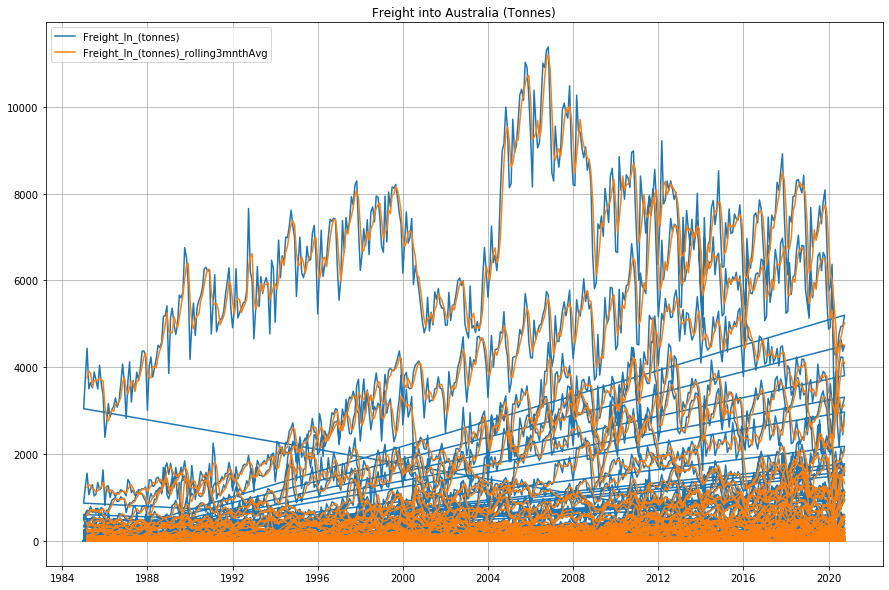

In [28]:
#visualise results. Best to refine to specific airlines or periods of interest for clear visualisation.
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(Q3_Total['Date'],Q3_Total['Freight_In_(tonnes)'],label='Freight_In_(tonnes)')
plt.plot(Q3_Total['Date'],Q3_Total['Freight_In_(tonnes)_rolling3mnthAvg'],label='Freight_In_(tonnes)_rolling3mnthAvg')
plt.legend(loc=2)
plt.title('Freight into Australia (Tonnes)')
plt.show()

Refining the resulting visualisation for specific airlines

Text(0.5, 1.0, 'Rolling Avg. Freight per Airline in 2018')

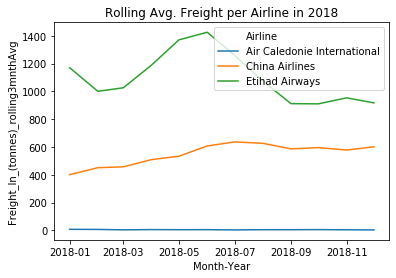

In [29]:
import seaborn as sns

#enter airlines of interest:

airlines = ['Air Caledonie International','China Airlines','Etihad Airways']

Q3_Visual = Q3_Total[Q3_Total['Airline'].isin(airlines)]
Q3_Visual = Q3_Visual[Q3_Visual['Year'] == 2018]

sns.lineplot(data=Q3_Visual, x = Q3_Visual['Month-Year'],y = Q3_Visual['Freight_In_(tonnes)_rolling3mnthAvg'], hue='Airline').set_title('Rolling Avg. Freight per Airline in 2018')

In [30]:
Q3_Total = Q3_Total[Q3_Total['Year'] == 2018]

In [31]:
#export results to csv
Q3_Total.to_csv('Question 3 - SBost.csv')

### Question 4: Which 3 airlines have the highest mail inbound/outbound ratio across the whole dataset?

For thus question, we'll need to calculate the mail inbound/outbound ratio.

Assumption: 

- Mail inbound and outbound will be calculated by aggregating all the mail in, and all the mail out, for each airline.

In [32]:
#Filter on the columns of interest.
df_Q4 = df[['Airline','Mail_In_(tonnes)','Mail_Out_(tonnes)','Month-Year']].copy()

#convert numerical values to float.
df_Q4[['Mail_In_(tonnes)','Mail_Out_(tonnes)']] = df_Q4[['Mail_In_(tonnes)','Mail_Out_(tonnes)']].astype(float)

In [33]:
#calculate the total mail inbound and outbound, for each airline.
Q4_Output = df_Q4.groupby(['Airline'])['Mail_In_(tonnes)','Mail_Out_(tonnes)'].sum()

In [34]:
Q4_Output['Mail Inbound: OutBound Ratio'] = [(Mail_In / Mail_Out)
                                            if (Mail_Out != 0) 
                                            else np.NaN
                                            for (Mail_In, Mail_Out,Mail_Out)
                                            in zip(Q4_Output['Mail_In_(tonnes)'],Q4_Output['Mail_Out_(tonnes)'],
                                            Q4_Output['Mail_Out_(tonnes)'] 
                                            )]

In [35]:
Q4_Output.head(100)

,Mail_In_(tonnes),Mail_Out_(tonnes),Mail Inbound: OutBound Ratio
Airline,,,
AOM French Airlines,29.365,0.000,NaN
Aeroflot Russian Intl A/l,6.922,0.012,576.833333
Aerolineas Argentinas,243.686,135.470,1.798819
Air Austral,0.000,0.000,NaN
Air Australia,0.000,0.000,NaN
...,...,...,...
Olympic Airways,2396.138,61.739,38.810768
Our Airline,1.455,14.614,0.099562
OzJet,0.000,0.000,NaN


In [36]:
Q4_Output = Q4_Output.sort_values(by='Mail Inbound: OutBound Ratio', ascending=False)

In [37]:
Q4_Output_Top3 = Q4_Output.head(3)
Q4_Output_Top3.head()

,Mail_In_(tonnes),Mail_Out_(tonnes),Mail Inbound: OutBound Ratio
Airline,,,
Asiana Airlines,5203.020,0.097,53639.381443
Middle East Airlines,17.460,0.012,1455.000000
Aeroflot Russian Intl A/l,6.922,0.012,576.833333


Looks like we get a lot of Mail with Asiana Airlines from Korea, but not a lot being sent back with them... Looks like Korean Air and Qantas Airways are the providers of choice to get mail going back the other way.

In [38]:
Q4_Output_Top3.to_csv('Question 4 - SBost.csv')

### BONUS: Using the dataset, identify an airline that may have changed name and explain your approach?

Had to sleep on this one... I like it!

First thought is to visualise the start and end of each airlines operation, to see if there is any clear insights.
 - Update: Abort mission. As expected, it's not immediately clear all the possible name changes.

While there's a few ways to go about this (nested list comprehension, loops... wikipedia...), I've opted for using operating periods of each airline to determine if one airline finishes operation, and another starts. This approach gives us a couple of possible scenarios to focus on:

1. An airline may operate, then cease operation for a time, before rebranding and launching in the future.
2. An airline may merge/change names, and there is no disruption to operation.

For the below response, I've considered assumption 2, which means if we find out which airlines started operating the next timestep after another finished operating, that gives us our shortlist! 

In [39]:
#let's firstly determine the minimum and maximum operating date for each airline.
Q5_mindates = df.groupby(['Airline'],as_index=False)[['Month-Year']].apply(min)
Q5_maxdates = df.groupby(['Airline'],as_index=False)[['Month-Year']].apply(max)

#let's put those dates together, and record the min and max date for each airlines operation.
Q5_Output = pd.merge(Q5_mindates, Q5_maxdates,  how='left', on=['Airline'])

#calculates the range of operation, in case it's of interest
#Q5_Output['Date Difference'] = Q5_Output['Month-Year_y'] - Q5_Output['Month-Year_x']
Q5_Output = Q5_Output.sort_values(by='Month-Year_x', ascending=True)
Q5_Output.head()

,Airline,Month-Year_x,Month-Year_y
138,Yugoslav Airlines,1985-01-01,1992-05-01
99,Pan American,1985-01-01,1986-02-01
37,Canadian Airlines Intl,1985-01-01,2000-12-01
36,British Airways,1985-01-01,2020-04-01
101,Philippine Airlines,1985-01-01,2020-10-01


In [41]:
#in case any other columns are added, refining to just the columns of interest for visualisation purposes.
Q5_v = Q5_Output[['Airline','Month-Year_x','Month-Year_y']].copy()
#Q5_v.set_index(['Month-Year_x'],inplace=True)

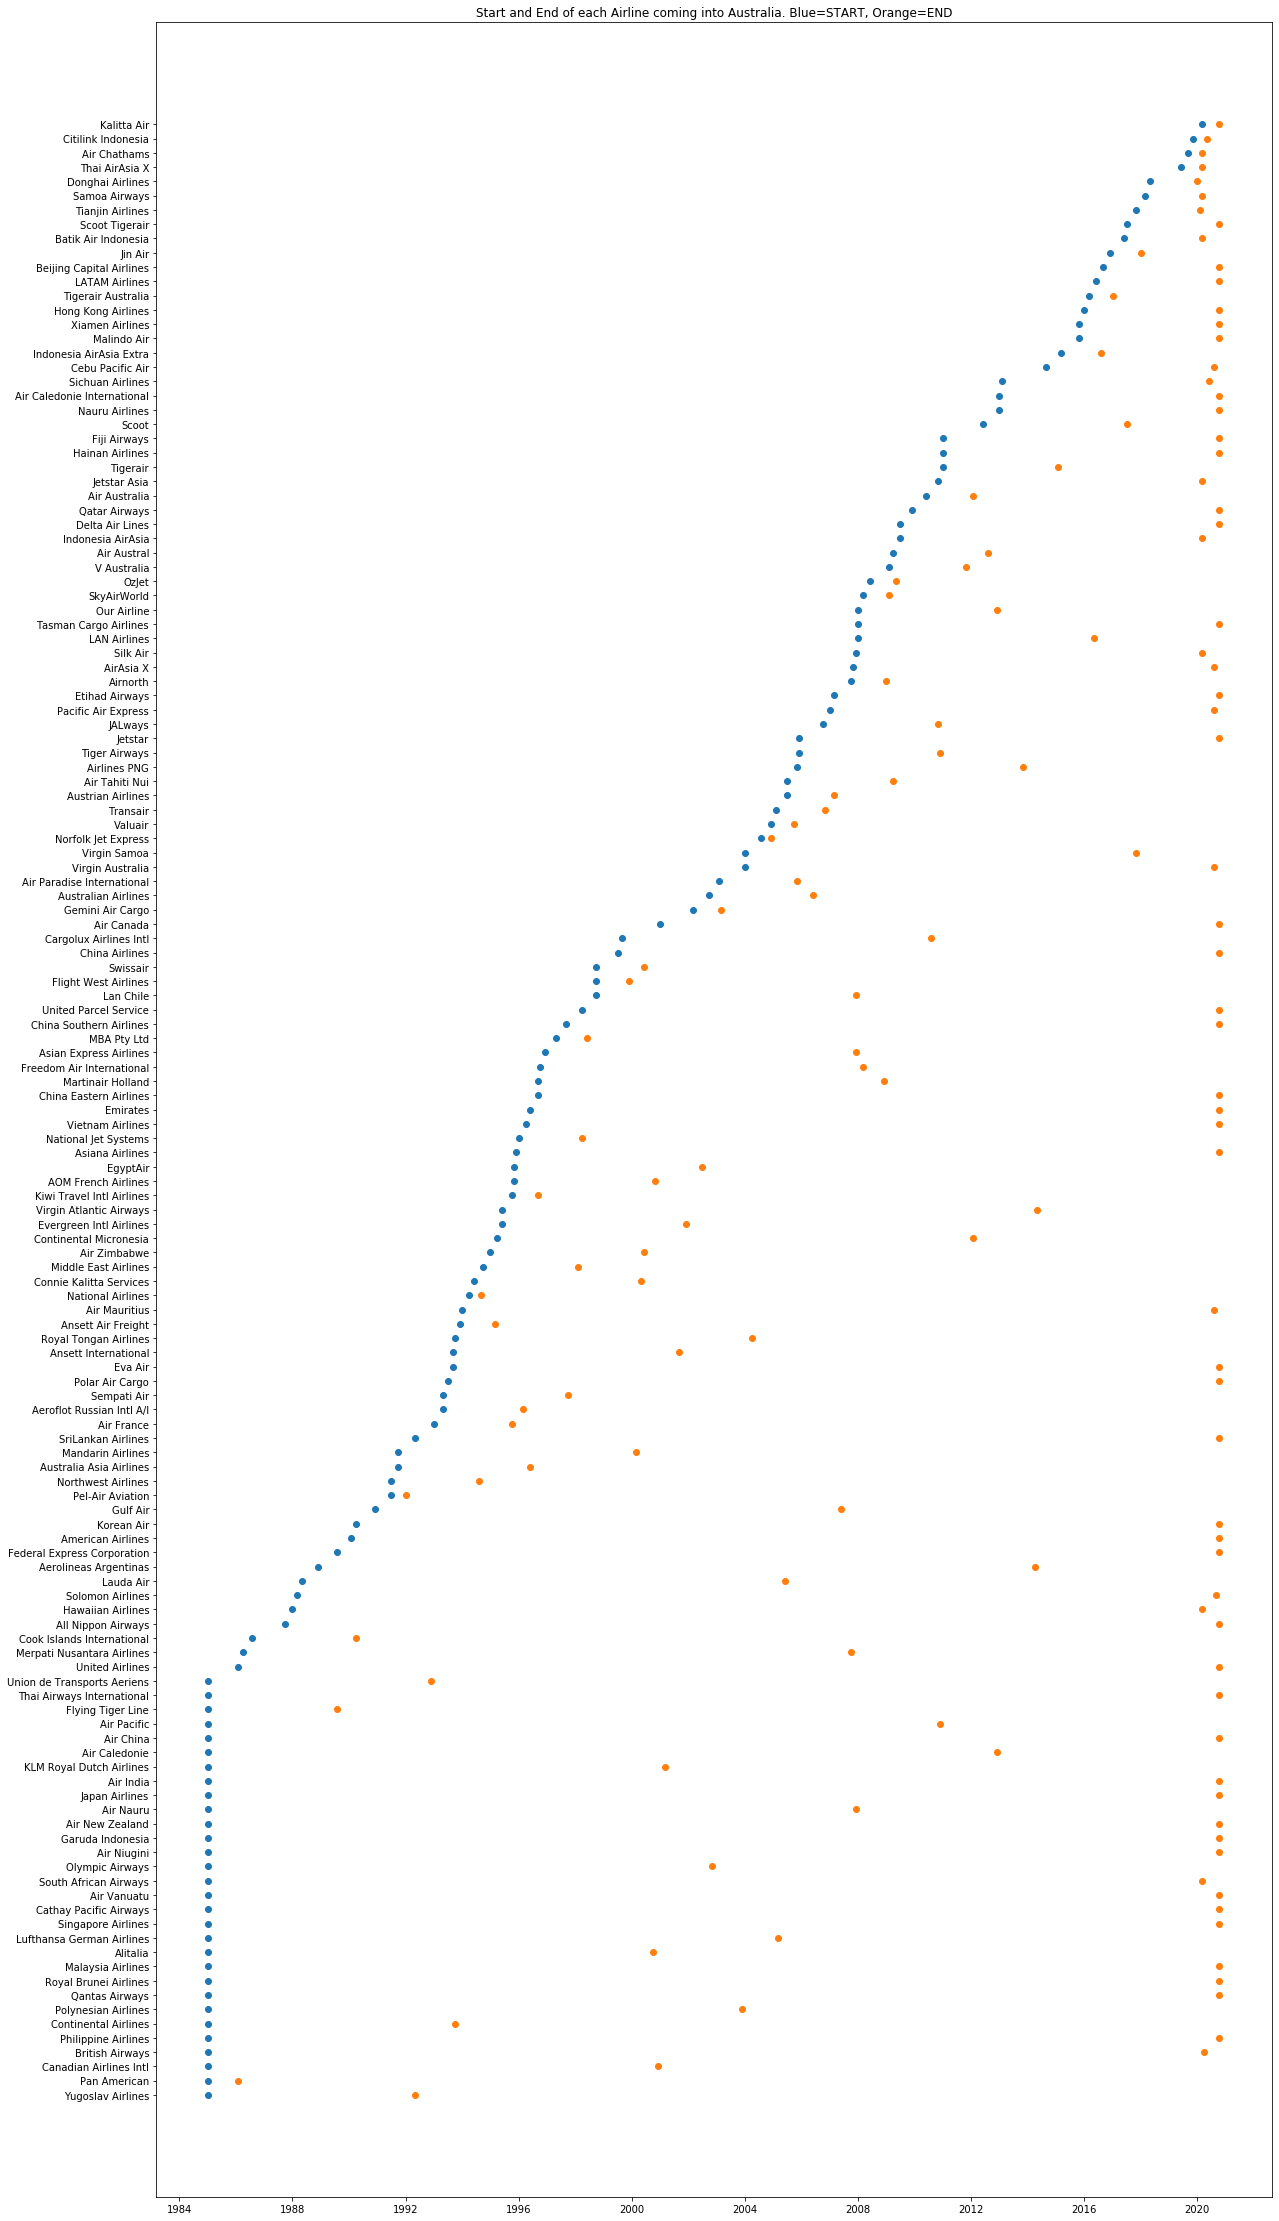

In [42]:
#visualisation of all airlines, and the periods in which they have been operating. Blue = FIRST, Orange=LAST.
plt.rcParams["figure.figsize"] = (20,40)
plt.scatter(Q5_v['Month-Year_x'], Q5_v['Airline'])
plt.scatter(Q5_v['Month-Year_y'], Q5_v['Airline'])
plt.title('Start and End of each Airline coming into Australia. Blue=START, Orange=END')
plt.show()

The key insight of interest here is, if one airline starts the month after another finishes, could this be from rebranding?

To answer this, we'll need to check if there are any airlines that have start dates equal to another airlines end date + 1 month.

In [43]:
#determine the next month after an airlines records end. 
Q5_v['End Date Add 1 Month'] = Q5_v['Month-Year_y']+pd.DateOffset(months=1)
Q5_v['Start Date Minus 1 Month'] = Q5_v['Month-Year_x']-pd.DateOffset(months=1)
Q5_v.head()

,Airline,Month-Year_x,Month-Year_y,End Date Add 1 Month,Start Date Minus 1 Month
138,Yugoslav Airlines,1985-01-01,1992-05-01,1992-06-01,1984-12-01
99,Pan American,1985-01-01,1986-02-01,1986-03-01,1984-12-01
37,Canadian Airlines Intl,1985-01-01,2000-12-01,2001-01-01,1984-12-01
36,British Airways,1985-01-01,2020-04-01,2020-05-01,1984-12-01
101,Philippine Airlines,1985-01-01,2020-10-01,2020-11-01,1984-12-01


In [44]:
#check if there is end dates for an airline, that occur one month before another airline starts operating.
first = Q5_v['Month-Year_y'].isin(Q5_v['Start Date Minus 1 Month'])
Airline_First = Q5_v.loc[first]

#check if there is start dates for an airline, that occur one month after another airline ceases operating.
second = Q5_v['Month-Year_x'].isin(Q5_v['End Date Add 1 Month'])
Airline_Second = Q5_v.loc[second]

#result = Matching.sort_values('Month-Year_x', ascending=True)
#result

In [45]:
#refine datasets to look at which airlines could be 'first' or 'second' in a possible rebranding flag.

First = Airline_First[['Airline','Month-Year_y']].copy()
Second = Airline_Second[['Airline','Month-Year_x']].copy()

First = First.sort_values(by='Month-Year_y', ascending=True)
Second = Second.sort_values(by='Month-Year_x', ascending=True)

print(First)
print(Second)

                         Airline Month-Year_y
128  Union de Transports Aeriens   1992-12-01
90             National Airlines   1994-09-01
27            Ansett Air Freight   1995-03-01
10                    Air France   1995-10-01
1      Aeroflot Russian Intl A/l   1996-03-01
76     Kiwi Travel Intl Airlines   1996-09-01
37        Canadian Airlines Intl   2000-12-01
103          Polynesian Airlines   2003-12-01
81                     Lauda Air   2005-06-01
132                      Valuair   2005-10-01
17    Air Paradise International   2005-11-01
88    Merpati Nusantara Airlines   2007-10-01
29        Asian Express Airlines   2007-12-01
80                     Lan Chile   2007-12-01
13                     Air Nauru   2007-12-01
23                      Airnorth   2009-01-01
16                   Air Pacific   2010-12-01
124                Tiger Airways   2010-12-01
5                  Air Caledonie   2012-12-01
96                   Our Airline   2012-12-01
125                     Tigerair  

Using the lists above the following review was conducted:

1. Review the end date for each airline, to see if it occurs one month before another starts.
2. Sense-check whether this is a likely rebranding.

E.g. 

National Airlines finishes operations in September, 1994. 
Middle East Airlines starts operating in October, 1994.
Coincidence?!?! Well, yes. Google tells me National Airlines is based out of Florida, and the Middle East Airlines operates out of... you guessed it... Not Florida. So, probably not a rebranding situation.

However, what about Union de Transports Aeriens, finishing operating in Decmeber 1992, and Air France kicking off in January 1993. Now my French is l'avarie (average), but that sounds possible!

Overall, there looks to be 12 airlines that do look to have changed names, and these are recorded below.

### First Name: Second Name
- Union de Transports Aeriens: Air France
- Canadian Airlines Intl: Air Canada
- Polynesian Airlines: Virgin Samoa
- Lauda Air: Austrian Airlines
- Kiwi Travel Intl Airlines: Freedom Air International
- Lan Chile: LAN Airlines
- Air Nauru: Our Airline
- Air Pacific: Fiji Airways
- Tiger Airways: Tigerair
- Our Airline: Naura Airlines
- Air Caledonie: Air Caledonie International
- LAN Airlines: LATAM Airlines

Fun Fact: Did Air France become AOM French Airlines?
Air France ceased recording data in October 1995, and AOM French Airlines started in November of 1995. Coincidence?!
Well, it looks like it is. They were competitors! Wikipedia, a good friend of mine, says:

"For most of the decade, the airline (AOM) fiercely competed with Air France on both the French domestic market and on the air routes to the French overseas territories. Due to inappropriate fleet management and overcapacity, the airline quickly accumulated huge debts and consequently ceased operations in 2001."

Simply an artefact of the dataset that we have, with no confirmation found that there was an acquisition. AOM French Airlines operated from ~1990 to 2001, with operations into Australia from 95-00. Operating with both Boeing 737-200 and 737-500's in their fleet, it served it's time, but came to an end.

So, who's bringing in the mail from France now, if it's not AOM French Airlines, or Air France?

Well, the dataset only records mail, freight and passengers up until 2012... Seems odd... Did we stop direct travel from Australia to France? Looks like it! Would we benefit from recording the place of Origin for a passengers transit, or just the data for direct flights with Australia we're interested in going forward? :D

Thanks for reading and your consideration!

Kind Regards,
Sam